In [461]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import matplotlib.colors as colors
import numpy as np
from scipy.optimize import nnls
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Smarter model, paper model

In [462]:
def merge_var(df):
    new_variables=["ProbabilityScalarArithmetic",
                   "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                   "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                   "ProbabilityVectorMemory", "ProbabilityBranch", "ProbabilityJump"]
    
    old_variables = [  'ProbabilityMemLoadVectorMemory', 'ProbabilityUnclassifiedBranch',
       'ProbabilityMemUpdateVectorLogic', 'ProbabilityMemUpdateVectorMemory',
       'ProbabilityMemStoreScalarLogic',
       'ProbabilityMemStoreVectorLogic', 
       'ProbabilityMemUpdateUnclassifiedLogic', 
       'ProbabilityMemUpdateScalarMemory',
       'ProbabilityMemStoreUnclassifiedMemory',
       'ProbabilityMemStoreVectorArithmetic', 'ProbabilityRegisterScalarLogic',
       'ProbabilityMemStoreVectorMemory', 'ProbabilityMemUpdateScalarLogic',
       'ProbabilityRegisterScalarArithmetic',
       'ProbabilityMemLoadScalarArithmetic', 'ProbabilityScalarBranch',
       'ProbabilityMemLoadVectorLogic',
       'ProbabilityRegisterScalarMemory',
       'ProbabilityRegisterVectorArithmetic',
       'ProbabilityRegisterUnclassifiedArithmetic',
       'ProbabilityMemUpdateScalarArithmetic', 'ProbabilityMemLoadScalarLogic',
       'ProbabilityMemLoadVectorArithmetic', 'ProbabilityMemLoadScalarMemory',
       'ProbabilityVectorBranch', 'ProbabilityMemLoadUnclassifiedArithmetic',
       'ProbabilityRegisterVectorLogic',
       'ProbabilityMemUpdateUnclassifiedArithmetic',
       'ProbabilityMemUpdateVectorArithmetic',
       'ProbabilityRegisterUnclassifiedLogic', 
       'ProbabilityMemLoadUnclassifiedLogic',
       'ProbabilityMemStoreUnclassifiedArithmetic',
       'ProbabilityRegisterUnclassifiedMemory',
       'ProbabilityMemLoadUnclassifiedMemory',
       'ProbabilityMemUpdateUnclassifiedMemory', 'ProbabilityUnclassifiedJump',
       'ProbabilityVectorJump','ProbabilityMemStoreScalarArithmetic',
       'ProbabilityRegisterVectorMemory', 
       'ProbabilityScalarJump', 
       'ProbabilityMemStoreUnclassifiedLogic', 
       'ProbabilityMemStoreScalarMemory', ]
    
    for new in new_variables:
        common=new[11:]
        old_list=list()
        for old in  old_variables:
            if common in old:
                old_list.append(old)
            if "Unclassified" in old:
                var=old.split("Unclassified")[-1]
                #print(var)
        df[new]=df[old_list].sum(axis=1)


    return df


In [463]:
def load_df_list():
    directory_list=["results_amd_1500"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    bench_name,cores=filename.split(".")[0].split("-")[1:]
                    df["name"]=bench_name
                    df["cores"]=int(cores)
                    df=merge_var(df.iloc[3:])
                    df_list.append(df)
                except Exception as e:
                    print(e)
    return df_list

In [464]:
def normalize_model(df):

    
    new_variables=["ProbabilityScalarArithmetic",
                   "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                   "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                   "ProbabilityVectorMemory", "ProbabilityBranch", "ProbabilityJump"]
    
    df[new_variables]=df[new_variables]/100
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]*128/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280
    option=4
    if option==1:
        for var in new_variables:
            df[var]=np.log(df["SystemCpuUsage"]+1)*df[var]
    if option==3:
        for var in new_variables:
            if "Branch" in var:
                df[var]=df["SystemCpuUsage"]*df[var]
                continue
            df[var]=np.log(df["SystemCpuUsage"]+1)*df[var]        
    if option==2:
        for var in new_variables:
            df[var]=np.log(df["SystemCpuUsage"]*df[var]+1)*df[var]
    if option==4:
        for var in new_variables:
            if "Logic" in var:
                df[var]=df["SystemCpuUsage"]*df[var]
                continue
            df[var]=np.log(df["SystemCpuUsage"]+1)*df[var]

    return df

In [465]:
independent_variables=["ProbabilityScalarArithmetic",
                   "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                   "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                   "ProbabilityVectorMemory", "ProbabilityBranch", "ProbabilityJump"]

In [469]:
df_list_train= load_df_list()
df = pd.concat(df_list_train)
print(df.name.unique())
exp_list=['branch','jump','copy','copy_mem','copy_mem_avx',
          'stream_avx','copy_mem','load_avx','daxpy_mem_avx_fma',
          'peakflops_avx_fma','load_mem','store_mem','store_mem_avx',
          'update_avx','stream_mem_avx_fma','dgemm']
df=df[df["name"].isin(exp_list)]

df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
df = normalize_model(df.copy())
A=df[independent_variables].to_numpy()
print(A.shape)
b=np.ones((A.shape[0],1))
A=np.hstack((A,b))
coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=5000)
intercept_1=coeff_1[-1]
print(f"Residual {error_1/A.shape[0]}, intercept {intercept_1}")
for name,value in zip(independent_variables,coeff_1):
    print(name,value)

['branch' 'copy' 'copy_mem' 'copy_mem_avx' 'daxpy_mem_avx_fma' 'jump'
 'load_avx' 'load_mem' 'logic' 'peakflops_avx_fma' 'store_mem'
 'store_mem_avx' 'stream_mem_avx_fma' 'update_avx' 'sleep' 'dgemm']
(3015, 8)
Residual 0.20311835189029473, intercept 309.2105899337185
ProbabilityScalarArithmetic 29.766308349149277
ProbabilityScalarLogic 0.0
ProbabilityScalarMemory 41.43563720491486
ProbabilityVectorArithmetic 44.37275731028661
ProbabilityVectorLogic 164.9239283105376
ProbabilityVectorMemory 41.480033850252276
ProbabilityBranch 18.88134631259711
ProbabilityJump 12.865207094246067


In [470]:
def assign_colors(labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    color_map = plt.get_cmap('tab20')  # You can change the color map here

    label_to_color = {}
    for i, label in enumerate(unique_labels):
        label_to_color[label] = color_map(i / num_labels)

    return label_to_color
df= load_df_list()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

#print(name_to_color)  # This will print the mapping of labels to colors

(305.0, 625.0)

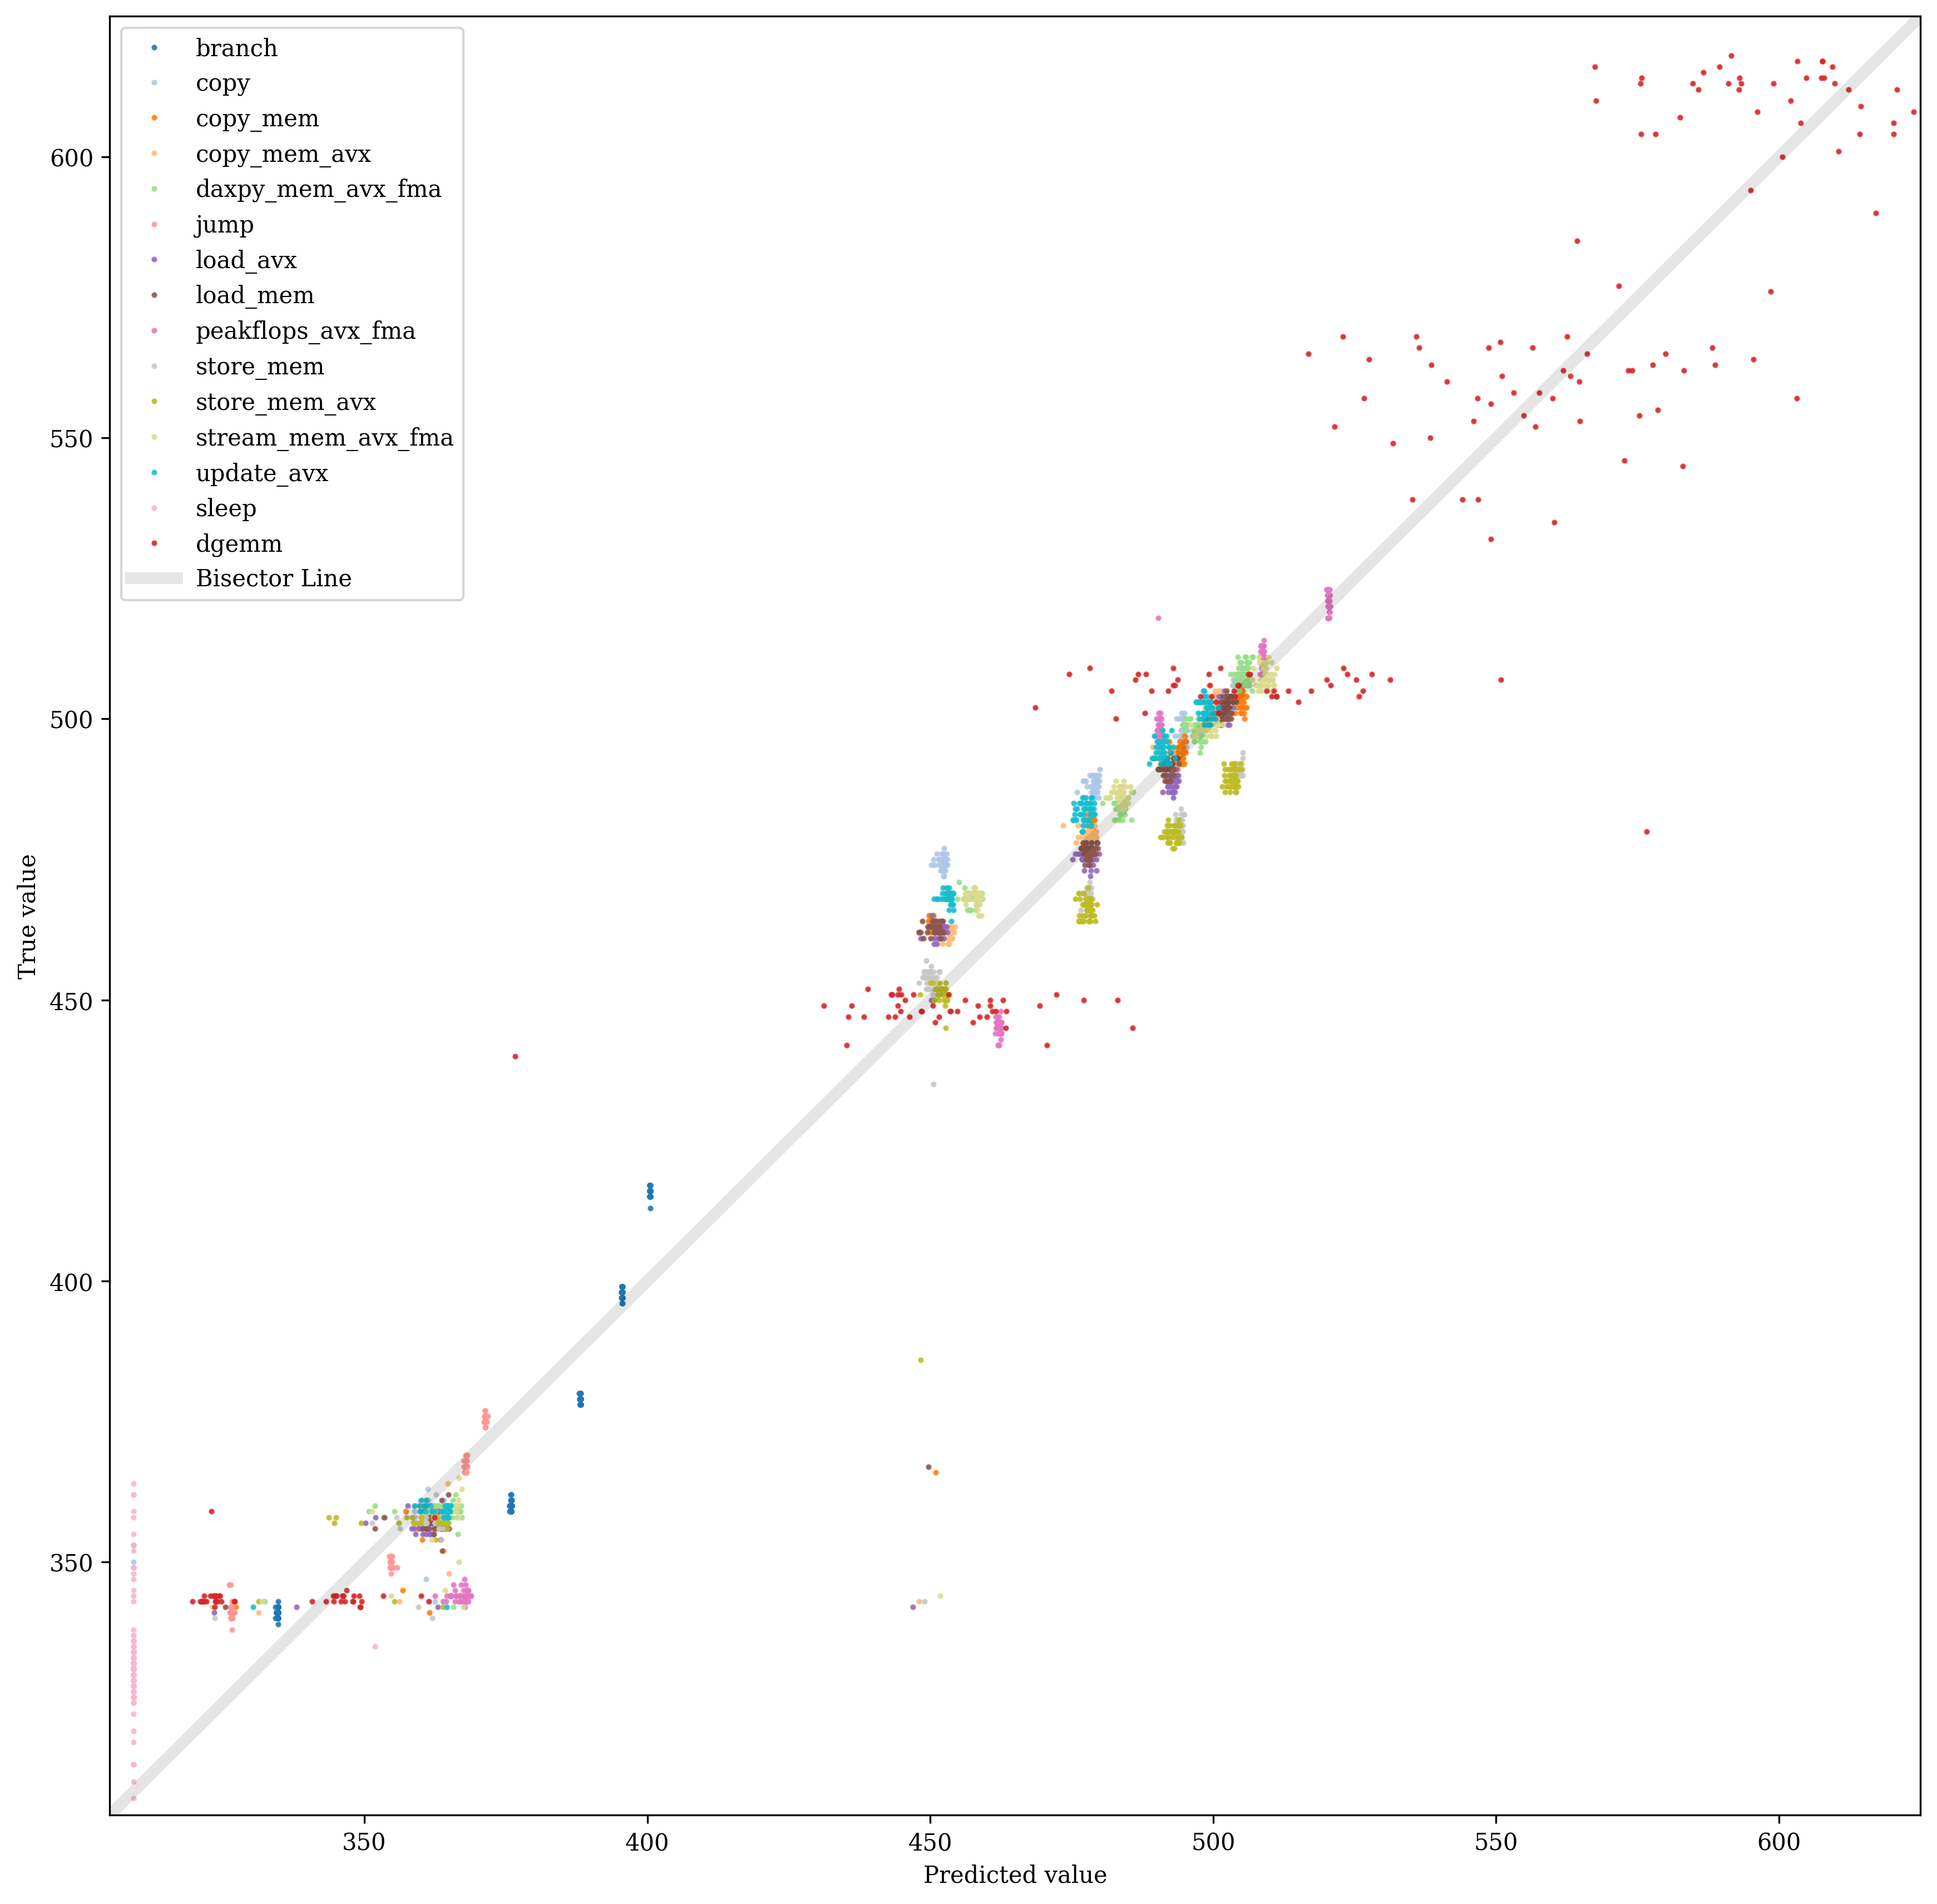

In [471]:
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list()
plt.figure(figsize=(14,14),dpi=300)

for df in df_list_test:
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df1 = normalize_model(df.copy())
    prediction=list()

    for row in df1[independent_variables].to_numpy():
        prediction.append(row@coeff_1[:-1] + intercept_1)
    df1["prediction"]=prediction
    if len(df) <1:
        continue
    test_name=df1["name"].iloc[0]
    if test_name=="logic":
        continue
    cores=df1["cores"].iloc[0]
    plt.plot(df1["prediction"],df1["Total_power"], '.', 
             markersize=3, 
             alpha=0.8,
             fillstyle='full',
             markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([305,625])
plt.ylim([305,625])

In [330]:
plt.rcParams["font.family"] = "DeJavu Serif"


df_list_test= load_df_list_test()
df=pd.concat(df_list_test)
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df["total_socket"]=df["SocketPower0"]+df["SocketPower1"]
#df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["total_socket"] > 200) | (df["total_power"] > 400)]
independent_variables = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']

for source in ['total_power', 'total_socket']:
    plt.figure(figsize=(3.5,3.5))
    color=[name_to_color[i] for i in df["name"]]

    for _,row in df.iterrows():
        plt.scatter(row["SystemCpuUsage"],row[source],s=4,label=row["name"], color=name_to_color[row["name"]])

    plt.ylabel(source)
    plt.xlabel("System CPU Usage")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(),ncol=2,handleheight=2.4, labelspacing=0.05)
    #plt.legend(by_label.values(), by_label.keys())
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.5),ncol=4, loc="lower center")
    plt.savefig(f"{source}.pdf", bbox_inches="tight")

NameError: name 'load_df_list_test' is not defined

                            OLS Regression Results                            
Dep. Variable:            Total_power   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     365.4
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:30:48   Log-Likelihood:                -19839.
No. Observations:                3668   AIC:                         3.970e+04
Df Residuals:                    3659   BIC:                         3.975e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

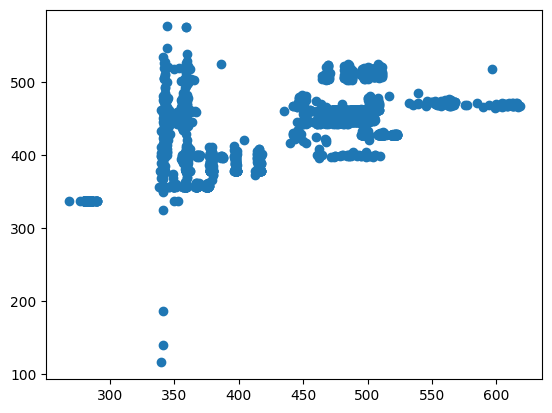

In [95]:
df_list_train= load_df_list()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]

["ProbabilityScalarArithmetic",
                   "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                   "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                   "ProbabilityVectorMemory", "ProbabilityBranch", "ProbabilityJump"]
results = smf.ols('Total_power ~  np.log(1+ProbabilityScalarArithmetic) + ProbabilityScalarLogic + np.log(1+ProbabilityScalarMemory) + np.log(ProbabilityVectorArithmetic+1) + \
                           ProbabilityVectorLogic + np.log(1+ProbabilityVectorMemory) + ProbabilityBranch + ProbabilityJump ',
                  data=df).fit()
print(results.summary())
plt.scatter(df["Total_power"],results.predict(df))

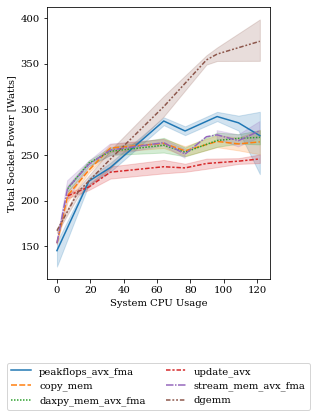

In [100]:
plt.rcParams["font.family"] = "DeJavu Serif"


df_list_test= load_df_list_test()
df=pd.concat(df_list_test)
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df["total_socket"]=df["SocketPower0"]+df["SocketPower1"]
#df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["total_socket"] > 250) | (df["total_power"] > 400)]
independent_variables = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']

tests=["peakflops_avx_fma", "daxpy_mem_avx_fma", "dgemm", "update_avx", "copy_mem", "stream_mem_avx_fma"]
frame = pd.DataFrame()
for source in ['total_socket']:
    plt.figure(figsize=(4,5))
    color=[name_to_color[i] for i in df["name"]]
    dfn = df[df["name"].isin(tests)]
    dfn["usage"] = (dfn["SystemCpuUsage"] - (dfn["SystemCpuUsage"] % 5)) * 1.28
    sns.lineplot(data=dfn, x="usage", y=source, hue="name", style="name")
    #for _,row in df.iterrows():
    #    print(row.head())
        #if (row["name"] in ["peakflops_avx_fma", "daxpy_mem_avx_fma","dgemm"]):
        #    sns.lineplot(data=row, x="SystemCpuUsage", y=source, hue=row["name"])
            #plt.scatter(row["SystemCpuUsage"],row[source],s=4,label=row["name"], color=name_to_color[row["name"]])

    plt.ylabel("Total Socket Power [Watts]")
    plt.xlabel("System CPU Usage")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(),ncol=1,handleheight=2.4, labelspacing=0.05)
    #plt.legend(by_label.values(), by_label.keys())
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.5),ncol=2, loc="lower center")
    plt.savefig(f"{source}-filled.pdf", bbox_inches="tight")

matplotlib.__version__

36
[25, 45, 65, 85, 105, 125]


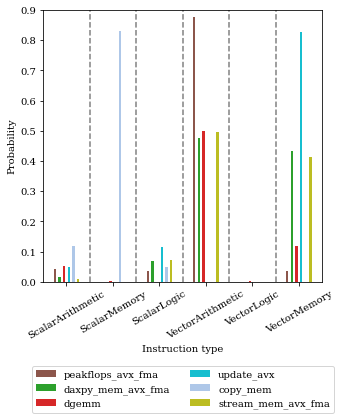

In [95]:
plt.rcParams["font.family"] = "DeJavu Serif"
cores=16
independent_variables=[ "ProbabilityScalarArithmetic",
                        	"ProbabilityScalarMemory", "ProbabilityScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

column_name_probability_labels=[ "ScalarArithmetic",
                        	"ScalarMemory", "ScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "VectorArithmetic", 	"VectorLogic",
                       "VectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

tests=["peakflops_avx_fma", "daxpy_mem_avx_fma", "dgemm", "update_avx", "copy_mem", "stream_mem_avx_fma"]

df_list_test= load_df_list_train()
df=pd.concat(df_list_test)

jitter=np.array([i/len(tests) for i in range(0,len(tests))])
plt.figure(figsize=(5,5))
offset=0
ticks=list()
for var in independent_variables:
    y=list()
    offset+=20
    for test in tests:
        y.append(df[(df["cores"]==32) & (df["name"]==test)][var].mean()/100)
    plt.bar(jitter*12+offset,y,width=1.0,label=tests,color=[name_to_color[t] for t in tests])   
    ticks.append(offset+5)

handles, labels = plt.gca().get_legend_handles_labels()
print(len(handles))
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.5),ncol=2, loc="lower center")
print(ticks)
plt.xticks(ticks=ticks, labels=column_name_probability_labels,rotation=30)
plt.xlabel("Instruction type")
plt.ylabel("Probability")
plt.xlim([15, 135])
plt.ylim([0, 0.9])

for i in range(len(ticks) - 1):
    plt.vlines(ticks[i] + 10, ymin=0, ymax=0.9, colors='gray', linestyles='dashed')
plt.savefig("histogram.pdf", bbox_inches='tight')

In [24]:
df_tmp=df[df["name"]=="dgemm"].copy()

In [25]:
df_tmp[independent_variables].mean()/100

ProbabilityScalarArithmetic    0.052839
ProbabilityScalarMemory        0.004029
ProbabilityScalarLogic         0.002649
ProbabilityVectorArithmetic    0.510796
ProbabilityVectorLogic         0.003750
ProbabilityVectorMemory        0.120059
dtype: float64

In [26]:
def normalize_model1(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    
    df[percentages]=df[percentages]/100
    Pidle = 351
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]*128/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280

    for var in independent_variables:
  #      df[var]=df[var]*df["SystemCpuUsage"]*TDP*2
        df[var]=np.log(df[var]*df["ProcessCpuUsage"] + 1) #*df["Total_socket"]
        
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    return df


In [27]:
def load_df_list_train_noise():
    directory_list=["results_1500/results_no_noise","results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
def load_df_list_test():
    directory_list=["results_1500/results_no_noise","results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
    

In [28]:
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
#df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000)
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

Residual 1007.6856888325165, intercept 353.3886553080839
ProbabilityScalarArithmetic 13.351666843501091
ProbabilityScalarMemory 23.988412716174278
ProbabilityScalarLogic 0.0
ProbabilityVectorArithmetic 16.80911587811535
ProbabilityVectorLogic 170.8737397393976
ProbabilityVectorMemory 24.38828633127049


{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

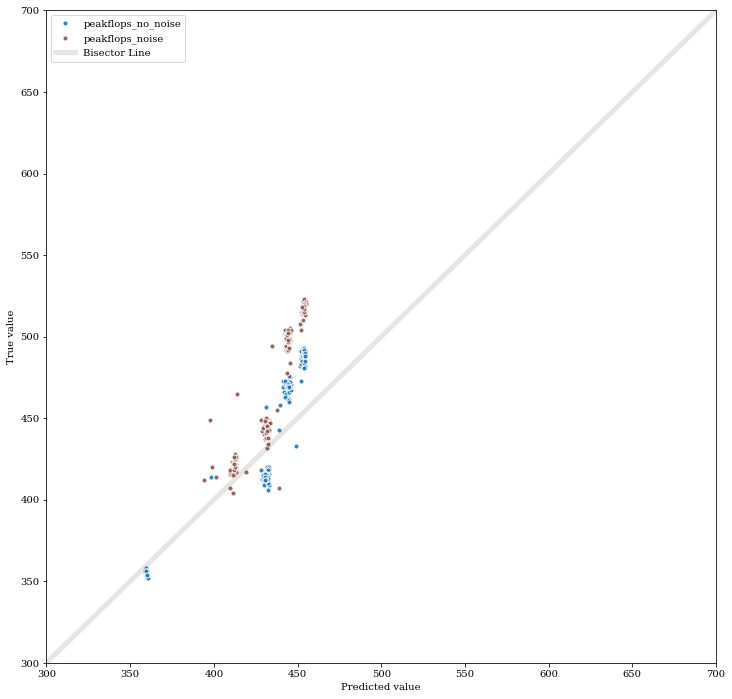

In [29]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                 markersize=5, 
                 alpha=0.9,
                 fillstyle='full',
                 markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

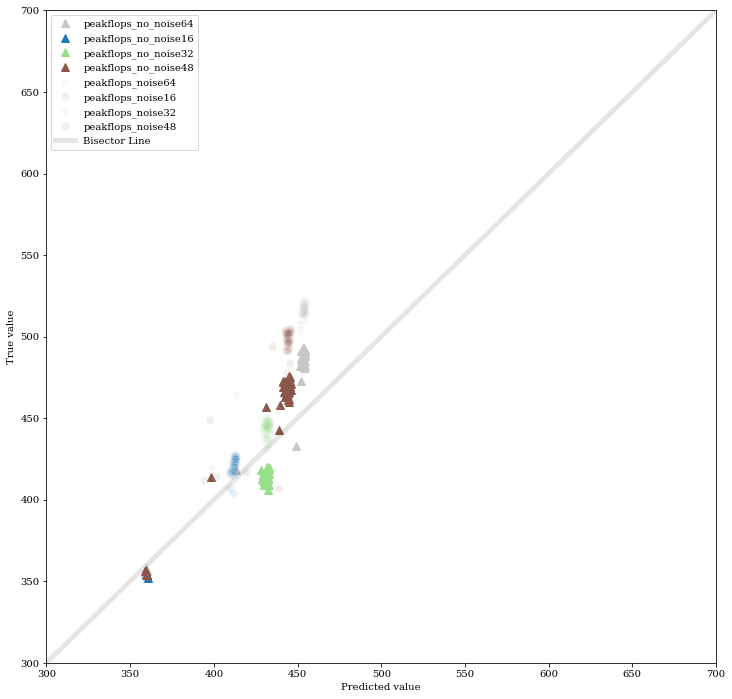

In [30]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        if test_name=="peakflops_no_noise":
            pass
            plt.plot(df1["prediction"],df1["Total_power"], '^', 
                     markersize=8, 
                     alpha=1.0,
                     fillstyle='full',
#                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name+f"{cores}",color=cores_to_color[cores])
        
        if test_name=="peakflops_noise":
            plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                     markersize=8, 
                     alpha=0.1,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name+f"{cores}",color=cores_to_color[cores])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

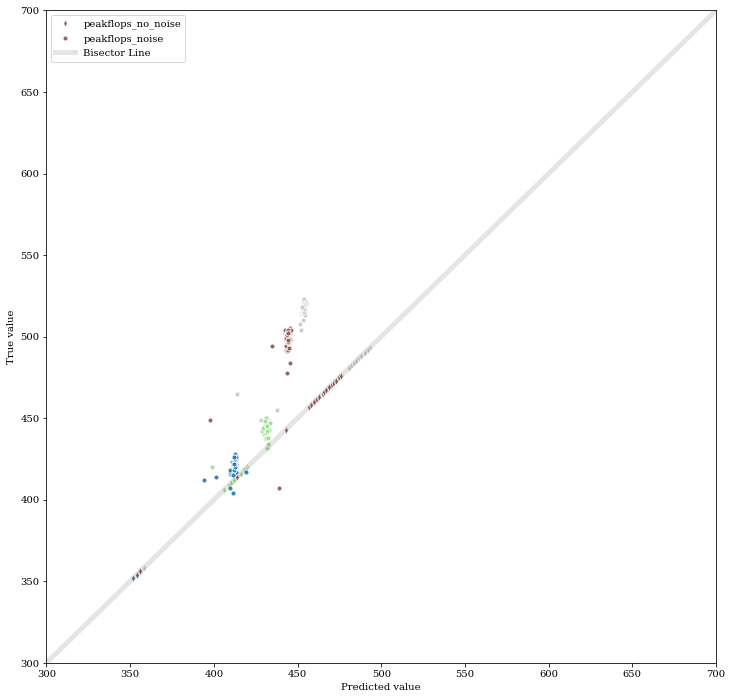

In [31]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        if test_name=="peakflops_no_noise":
            pass
            plt.plot(df1["Total_power"],df1["Total_power"], 'd', 
                     markersize=5, 
                     alpha=0.9,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name,color=cores_to_color[cores])
        
        if test_name=="peakflops_noise":
            pass
            plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                     markersize=5, 
                     alpha=0.9,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name,color=cores_to_color[cores])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


Text(0.5, 0, 'experiment')

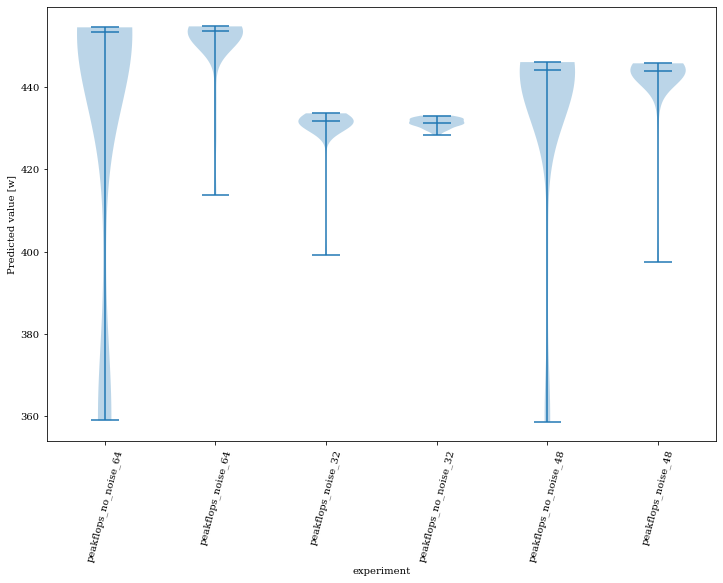

In [32]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,8))

columns=list()
columns_labels=list()
for df in df_list_test:
    
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
    df1 = normalize_model1(df.copy())
    if len(df) <1:
        continue
    test_name=df1["name"].iloc[0]
    cores=df1["cores"].iloc[0]
    if cores==8 or cores==16:
        continue
    prediction=list()
    
    for row in df1[independent_variables].to_numpy():
        prediction.append(row@coeff_1[:-1] + intercept_1)
    df1["prediction"]=prediction

    test_name=df1["name"].iloc[0]
    cores=df1["cores"].iloc[0]
    
    columns.append(df1["prediction"])
    columns_labels.append(test_name+f"_{cores}")
    
#    if test_name=="peakflops_no_noise":
#        plt.violinplot(df1["prediction"])
        
#    if test_name=="peakflops_noise":
#        plt.violin(df1["prediction"])
#for i in range(len(columns)/2):
columns[1],columns[3]=columns[3],columns[1]
columns_labels[1],columns_labels[3]=columns_labels[3],columns_labels[1]

columns[2],columns[4]=columns[4],columns[2]
columns_labels[2],columns_labels[4]=columns_labels[4],columns_labels[2]

violin_parts = plt.violinplot(columns, showmedians=True)
plt.xticks([y + 1 for y in range(len(columns))],
                  labels=columns_labels,rotation=90-15)


#plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.ylabel("Predicted value [w]")
plt.xlabel("experiment")
#plt.xlim([300,700])
#plt.ylim([300,700])

In [21]:
def load_df_noise():
    directory_list=["results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_no_noise():
    directory_list=["results_1500/results_no_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list

In [22]:
Pstatic=345.9
Cores=16

In [23]:
df=pd.concat(load_df_noise())

In [24]:
df=df[df["cores"]==Cores]

In [25]:
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
print(f"E[total-static] {df["Total_power"].mean()-Pstatic}")

SyntaxError: invalid syntax (<ipython-input-25-291ed46265a3>, line 2)

In [ ]:
df=pd.concat(load_df_no_noise())
df=df[df["cores"]==Cores]
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
print(f"E[total-static] {df["Total_power"].mean()-Pstatic}")